# Ordinary exam in Introduction to programming and numerical analysis

In [174]:
import numpy as np
import pandas as pd
import datetime as dt
from types import SimpleNamespace
from copy import copy
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from scipy import interpolate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Windmill industry in Denmark

This exercise deals with the power generated by windmills in Denmark. As windmills are considered an important element in the transition to a zero emission economy we should take a closer look at the electricity production stemming from them.

To this end, you need to download the official data set containing all windmills in Denmark which produced by the Danish Energy Agency. You can download it using the module `requests` and then save it as the xlsx file `windmills.xlsx`. This is done in the cell below. 

In [175]:
import requests

url = "https://ens.dk/sites/ens.dk/files/Statistik/anlaeg.xlsx"
r = requests.get(url)

with open('windmills.xlsx', 'wb') as xls_file:
    xls_file.write(r.content)   

*Note: `requests` is in the Anaconda distribution, so it should be available to you. If it is not, install it by running `python -m pip install requests` in your terminal.*   

By inspecting `windmills.xlsx` you'll see it has two sheets: 1) `IkkeAfmeldte-Existing turbines` which holds mills (turbines) currently in use and 2) `Afmeldte-Decommissioned` which are no longer in service. Throughout the rest of the exercise, you need to use data from both of them.

### Question 1

1. Load the two sheets of `windmills.xlsx` into your notebook and combine them into one pandas DataFrame. Note that you need to do some data cleaning in the process. For instance, you can disregard the variables which are not present in both sheets. You can decide for yourself whether you want to use English or Danish column names.  
2. Plot the development in total electricity production from windmills between 1977-2021. You may use GWh (1 million KWh) as unit. 


In [176]:
# 1. Loading spread sheets and cleaning data
sheets = ["IkkeAfmeldte-Existing turbines", "Afmeldte-Decommissioned"]
dfs = {}
years = [*range(1977,2022)]

use_cols = ['Turbine identifier (GSRN)',
 'Date of original connection to grid',
 'Capacity (kW)',
 'Rotor diameter (m)',
 'Hub height (m)',
 'Manufacture',
 'Local authority no',
 'Local authority\nname',
 'Type of location',
 'X (east) coordinate\nUTM 32 Euref89',
 'Y (north) coordinate\nUTM 32 Euref89']

# i. Fixing messy placement of headers
for s in sheets:
   raw_A = pd.read_excel('windmills.xlsx', skiprows=9, usecols="A:P", sheet_name=s)
   raw_A.drop([*range(8)], inplace=True)
   r = [c in use_cols for c in raw_A.columns.to_list()] 
   raw_A = raw_A.loc[:, r]
   raw_A.reset_index(inplace=True, drop=True)
   
   raw_B = pd.read_excel('windmills.xlsx', skiprows=8, usecols="Q:BK",
                       sheet_name=s)
   raw_B.drop([*range(9)], inplace=True)
   Bcols = [c in years for c in raw_B.columns.to_list()]
   raw_B = raw_B.loc[:, Bcols]
   raw_B.reset_index(inplace=True, drop=True)

   dfs[s] = raw_A.join(raw_B)

# ii. Collecting active and decomissioned mills into one data set
mills = pd.concat(dfs.values())

# iii. Shorter names 
mills = mills.rename(columns={'Turbine identifier (GSRN)' : 'id', 
 'Date of original connection to grid': 'initdate',
 'Capacity (kW)': 'capacity',
 'Rotor diameter (m)': 'diameter',
 'Hub height (m)': 'height',
 'Manufacture': 'manufacture',
 'Local authority no': 'mun_id',
 'Local authority\nname': 'mun_name',
 'Type of location':'location',
 'X (east) coordinate\nUTM 32 Euref89' : 'x',
 'Y (north) coordinate\nUTM 32 Euref89': 'y'})

# iv. Discard rows with totals - no date
nan_idx = mills.initdate.isna() == False
mills = mills.loc[nan_idx,:]

# v. Year of origination
mills.initdate = pd.to_datetime(mills.initdate, infer_datetime_format=True)
mills['init_year'] = mills.initdate.dt.year 
mills.reset_index(inplace=True, drop=True)

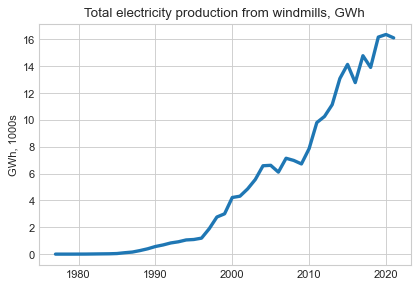

In [177]:
# 2. Calculate and plot total energy production 
total_gwh = mills[years].sum() / 1e6 # 1Gw = 1_000_000Kw 

fig,ax = plt.subplots(dpi=80) 
ax.plot(total_gwh/1e3, linewidth=3)
ax.set_title("Total electricity production from windmills, GWh")
ax.set_ylabel("GWh, 1000s");


### Question 2

We now want to know how the capacity of electricity production has changed over the years. For this we need two variables `Date of original connection to grid` and `Capacity (kW)`. The first indicates when a mill was initiated and the other its production capacity. 
1. Calculate and plot the development in **average**  and  **maximum** capacity of turbines based on their year of initialization (1977-2021)  
    **Note:** capacity is measured in KW, so you need to multiply with the number of hours pr year to make it comparable with annual production. 
2. To get a cleaner view of the trends, compute and plot the 7 year moving average of annual mean capacity and annual max capacity.   

    $\text{ma}^7(x_t) = \frac{x_{t-3}+x_{t-2}+...+x_{t}+...+x_{t+3}}{7}$
3. Finally, compute the **total capacity** of all windmills in Denmark in each year. Plot total capacity together with actual production as calculated in Question 1.  
    **Note:** the capacity of a turbine should only be included for the years when it is connected to the grid.    

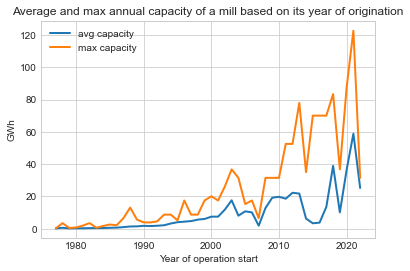

In [178]:
# 1. Average and maximum capacity each year
hours = 24*365
K_to_G = 1_000_000

avg_cap = mills.groupby(['init_year'])['capacity'].mean() * hours/K_to_G
max_cap = mills.groupby(['init_year'])['capacity'].max() * hours/K_to_G

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
avg_cap.plot(ax=ax, label='avg capacity', linewidth=2)
max_cap.plot(ax=ax, label='max capacity', linewidth=2)
ax.legend()
ax.set_xlabel('Year of operation start')
ax.set_ylabel('GWh')
ax.set_title('Average and max annual capacity of a mill based on its year of origination')
ax.legend(frameon=False);


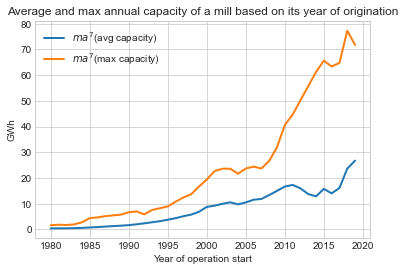

In [179]:
# 2. 7-year moving average. One option is to use the function 'rolling' which is inherent in a pandas data frame.  
ma_cap = pd.DataFrame({'avg_cap': avg_cap, 'max_cap': max_cap})
ma_cap['avg_ma'] = ma_cap.avg_cap.rolling(7, center=True).mean()
ma_cap['max_ma'] = ma_cap.max_cap.rolling(7, center=True).mean()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ma_cap.avg_ma.plot(ax=ax, label='$ma^7$(avg capacity)', linewidth=2)
ma_cap.max_ma.plot(ax=ax, label='$ma^7$(max capacity)', linewidth=2)
ax.legend()
ax.set_xlabel('Year of operation start')
ax.set_ylabel('GWh')
ax.set_title('Average and max annual capacity of a mill based on its year of origination');


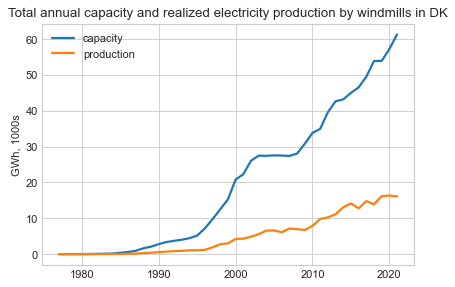

In [180]:
# 3. Total capacity of all windmillls in DK. 
on_grid = ~mills.loc[:,years].isna() # Windmills will only have non-na observations for years when they are online
grid_cap = on_grid[years].multiply(mills.capacity, axis="index")

total_gwh_capacity = grid_cap[years].sum() * hours/K_to_G
total_gwh_production = mills[years].sum()/K_to_G


fig, ax = plt.subplots(dpi=80)
ax.plot(total_gwh_capacity/1e3, label='capacity', linewidth=2)
ax.plot(total_gwh_production/1e3, label='production', linewidth=2)
ax.set_ylabel('GWh, 1000s')
ax.set_title('Total annual capacity and realized electricity production by windmills in DK')
ax.legend();

### Question 3

There is a lot of debate about the visual impact on the landscape from windmills. This exercise deals with the relationship between windmill size and productivity to get a sense of the tradeoff. You can solve it in many different ways depending on your preferences. The important thing is that the results are clear. 

1. Compute and plot the relationship between height of windmills and their electricity production in 2021. The variable `Hub height (m)` indicates the height of a mill in meters. One possible approach is to discretize the height variable and compute the median electricity production within each bin. But you can also apply a statistical model of your own choosing.
2. Repeat the method you chose above, but now group over the type of location as well. Locations are described by the variable `Type of location` and can be either *off-shore* ("HAV") or *on-shore* ("LAND","Land"). When plotting the results, use common limits on the y-axis for better comparison.  
4. Finally, we dig into the productivity of on-shore vs. off-shore mills.   
Compute and plot the *average difference* between annual capacity and annual production for mills on-shore and mills off-shore in each year 1990-2021.  

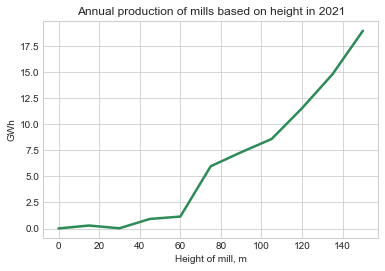

In [181]:
# 1. Here we bin the height of mills by 15m. 
# Notice: some of the largest mills are connected to the grid in late 2021, which distorts the picture. 
# Only mills connected before 2021 are therefore included.
bin_width = 15
mills['height_bin'] = np.ceil(mills.height / bin_width) * bin_width
mills.loc[mills.init_year==2021, 'height_bin'] = np.nan # discard mills from 2021, requires the dropna argument below
height_gwh = mills.groupby(['height_bin'], dropna=True)[2021].median()/K_to_G

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(height_gwh, linewidth=2.5, color='seagreen')
ax.set_ylabel('GWh')
ax.set_xlabel('Height of mill, m')
ax.set_title('Annual production of mills based on height in 2021');


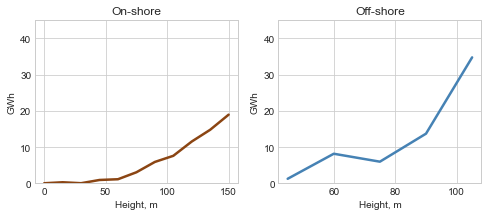

In [182]:
# 2. Compare capacity of onshore vs offshore mills 
# a. Correct messy capitalization in data
mills['location_type'] = [v.lower() for v in mills.location]

# b. Compute annual production based on height bins and location
height_loc_gwh = (mills.groupby(['height_bin', 'location_type'], 
                        dropna=True)[2021].median()/K_to_G).to_frame()
height_loc_gwh.reset_index(inplace=True, drop=False)

onshore = height_loc_gwh.loc[height_loc_gwh.location_type == 'land', :]
offshore = height_loc_gwh.loc[height_loc_gwh.location_type == 'hav', :]

# c. Plot onshore and offshore production
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(onshore.height_bin, onshore[2021], linewidth=2.5, color='saddlebrown');
ax1.set_ylim((0,45))
ax1.set_ylabel('GWh')
ax1.set_xlabel('Height, m')
ax1.set_title('On-shore');

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(offshore.height_bin, offshore[2021], linewidth=2.5, color='steelblue');
ax2.set_ylim((0,45))
ax2.set_ylabel('GWh')
ax2.set_xlabel('Height, m')
ax2.set_title('Off-shore');


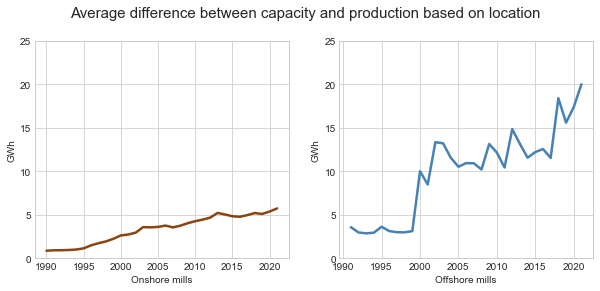

In [183]:
# 3. Average difference between capacity and production onshore vs offshore
period = [*range(1990,2022)]
grid_cap_diff = (grid_cap.loc[:,period]*hours - mills.loc[:,period])/K_to_G
grid_cap_diff['location_type'] = mills.location_type
cap_diff = grid_cap_diff.groupby(['location_type'])[period].mean()

fig = plt.figure(figsize=(10, 4))
fig.suptitle('Average difference between capacity and production based on location',fontsize=15, y=1.0)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(cap_diff.loc['land'], linewidth=2.5, color='saddlebrown')
ax1.set_ylim((0, 25))
ax1.set_ylabel('GWh')
ax1.set_xlabel('Onshore mills')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(cap_diff.loc['hav'], linewidth=2.5, color='steelblue')
ax2.set_ylim((0, 25))
ax2.set_ylabel('GWh')
ax2.set_xlabel('Offshore mills');

# A discrete-continuous consumption-saving model

Here we will consider a modification to the 2-period consumption saving model.   
In addition to making a consumption-saving choice in the first period, there is now also a binary choice of whether or not to attend costly education. Taking an education is in this model associated with higher expected earnings in period 2 but it comes at a monetary cost in period 1.   

**Second period**  
Household gets utility from **consuming** and **leaving a bequest**:

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

**First period**   
Household gets utility from consuming. It takes into account that if choosing to go to school today, expected income will be higher in second period.

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1,s}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
s& = \begin{cases} 
1 & \text{if study in period 1} \\
0 & \text{otherwise}
\end{cases}\\
a_1&=m_1-c_1-\tau s\\
m_2&= (1+r)a_1+y_2 \\
y_{2}&= \begin{cases}
\bar{y} + \gamma s +\Delta & \text{with prob. }p\\
\bar{y} + \gamma s -\Delta & \text{with prob. }1-p 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

* $s$ is a binary indicator for whether the agent chooses to study in period 1.  
* $c$ is consumption
* $\gamma$ is the income premium associated with having studied 
* $\tau$ is the monetary cost of studying, paid in period 1
* $m$ is cash-on-hand  
* $a$ is end-of-period assets
* $\bar{y}$ is base income in period 2
* $y_2$ is total realized income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving if $p = 0.5$)
* $r$ is the interest rate
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $a\geq0$ ensures the household *cannot* borrow

**Hint:** the study choice is discrete (and thus not differentiable) which means that it cannot be optimized for in the same manner as the continuous consumption choice. Therefore, you need to solve the consumption problem *for each* of the two study choices and pick the **combination** of studying and consuming that yields highest value as the model solution.   

In [184]:
# Parameters
rho = 8.0
nu = 0.1
kappa = 1  
beta = 0.90

tau = 0.8
gamma = 1.2
ybar = 1.5
r = 0.04
p = 0.5
Delta = 0.4

m_min = tau+1e-5    # minimum value for m - must be possible to pay for studying
m_max = 5.0         # maximum value for m

### Question 1  
1. Solve the model for the parameters above. 
2. Plot $v_1(m_1)$ and $v_2(m_2)$. Comment.
3. Plot the optimal consumption function $c_1^{*}(m_1)$ and $c_2^{*}(m_2)$ in one graph. Comment on the shapes of the functions.
4. Plot the optimal study choice function $\mathbb{I}^{s*}(m_1)$. Comment on the shape of the function.


In [185]:
import question2 as dc_model
mp = SimpleNamespace()

# model parameters
mp.rho = rho
mp.nu = nu 
mp.kappa = kappa
mp.beta = beta 

mp.tau = tau 
mp.gamma = gamma
mp.ybar = ybar 
mp.r = r 
mp.p = p 
mp.Delta = Delta 

mp.m_min = m_min 
mp.m_max = m_max 
mp.Nm = 500

# 1. Solve model
m1_grid, c1_func, s_func, v1_func, m2_grid, c2_func, v2_func, v1_schoice = dc_model.solve(mp)


(1.0, 4.0)

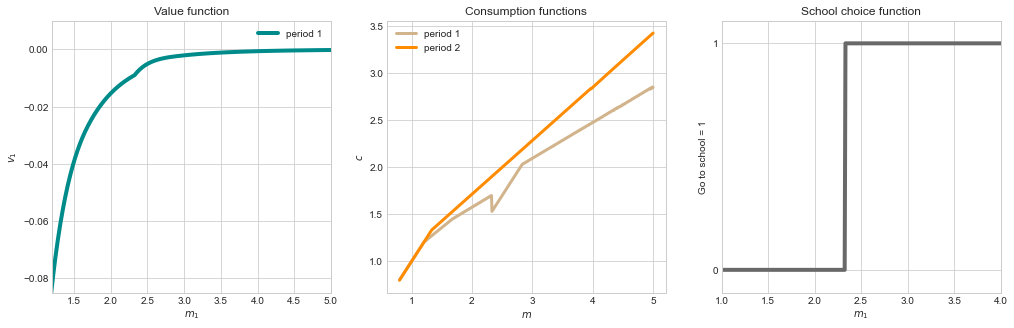

In [186]:

fig = plt.figure(figsize=(17, 5))

# 2. Value functions
ax = fig.add_subplot(1, 3, 1)
ax.plot(m1_grid, v1_func, label='period 1', color="darkcyan", linewidth=4)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('Value function')
ax.set_ylim((-0.085, 0.01))
ax.set_xlim((1.2, 5.0))
ax.legend();

# 3. Consumption functions
ax = fig.add_subplot(1, 3, 2)
ax.plot(m1_grid, c1_func, label='period 1', color='tan', linewidth=3)
ax.plot(m2_grid, c2_func, label='period 2',color='darkorange', linewidth=3)
ax.set_xlabel('$m$')
ax.set_ylabel('$c$')
ax.set_title('Consumption functions')
ax.legend();

# 4. School choice function
ax = fig.add_subplot(1, 3, 3)
ax.plot(m1_grid, s_func, label='Schooling', color="dimgrey", linewidth=4)
ax.set_xlabel('$m_1$')
ax.set_ylabel('Go to school = 1')
ax.set_title('School choice function')
ax.set_yticks([0,1])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([1.0, 4.0])
#ax.grid(False);

In [187]:
# Locate grid point where schooling is chosen
idx = np.where(np.diff(s_func > 0.99))[0]
print('Point in m1 where s goes from 0 to 1:', np.round(m1_grid[idx][0],3))

Point in m1 where s goes from 0 to 1: 2.323


**Remarks** From the school choice function, we can see that for all $m_1 > 2.28$, the agent will choose to go to school whereas this not chosen for any $m_1$ below this point. Going to school costs $\tau$ units of cash in period 1. Therefore, we also see a discontinuity in the period 1 consumption function at that point. 

Going to school yields a higher wage in the second period. The agent takes account for this when letting the consumption share increase at a faster rate along $m_1$ immediately after the point where schooling is chosen.  

Note that the discrete jump in income from choosing school is also visible in the value function of period 1. It too has a kink at $m_1=2.28$ stemming from the expectation of higher income in period 2.  

It should be noted that the kink in the value function arises due to the fact that we are taking the upper envelope over 2 value functions (one where schooling is not chosen and one where it is) and the kink appears exactly where the two cross. This is illustrated below.     

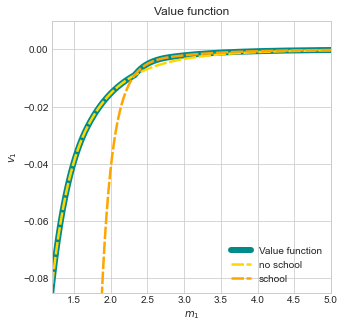

In [188]:
# Illustration of value function in period 1 as an upper envelope. 
# That is, over 2 school-choice specific value functions
upper = [np.max(v) for v in v1_schoice]

fig = plt.figure(figsize=(17, 5))

# 2. Value functions
ax = fig.add_subplot(1, 3, 1)
ax.plot(m1_grid, upper,label='Value function', color="darkcyan", linewidth=6)
ax.plot(m1_grid, v1_schoice[:,0], label='no school',
        color="gold", linewidth=2.5, linestyle=(0,(5,1)))
ax.plot(m1_grid, v1_schoice[:,1], label='school',
        color="orange", linewidth=2.5, linestyle=(0,(5,1)))
ax.set_ylim((-0.085,0.01))
ax.set_xlim((1.2,5.0))
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('Value function')
ax.legend();


### Question 2  
1. Given the wage premium on education, compute the **smallest** education cost $\tau$ such that an agent with $m_1 = 3.0$ will **no longer** choose to study.  
    **Hint**: there are different ways of obtaining that number. A bisection algorithm is one possibility.

In [189]:
mp_s=copy(mp)
eps = 1e-5

# Obtain solution for period 2
m2_grid,v2_func,_ = dc_model.solve_last_period(mp_s)
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func,bounds_error=False,fill_value=None)

# Define function to output study choice in period 1
def study_choice(mp_s): 
    return dc_model.solve_single_period(mp_s, v2_func_interp, [3.0])[3][0]

# Call bisection algorithm
tau_max_school, tau_min_noschool, n_iter = dc_model.bisection_search(
    mp_s.tau, mp_s.tau*2, 'tau', study_choice, 1.0, mp_s, eps, True)

print(f'\nSmallest tau that discourages studying equals is found in {n_iter:2d} iterations')
mp_s.tau = tau_max_school
print(f'At tau={tau_max_school:1.5f} the agent will choose to study? {study_choice(mp_s)==1!s}')

mp_s.tau = tau_min_noschool
print(f'At tau={tau_min_noschool:1.5f} the agent will choose to study? {study_choice(mp_s)==1!s}') 

 0 current midpoint = 1.200000
 1 current midpoint = 1.000000
 2 current midpoint = 1.100000
 3 current midpoint = 1.150000
 4 current midpoint = 1.125000
 5 current midpoint = 1.112500
 6 current midpoint = 1.118750
 7 current midpoint = 1.121875
 8 current midpoint = 1.123438
 9 current midpoint = 1.122656
10 current midpoint = 1.122266
11 current midpoint = 1.122461
12 current midpoint = 1.122559
13 current midpoint = 1.122607
14 current midpoint = 1.122632
15 current midpoint = 1.122644
16 current midpoint = 1.122650

Smallest tau that discourages studying equals is found in 17 iterations
At tau=1.12265 the agent will choose to study? True
At tau=1.12266 the agent will choose to study? False


In [190]:
print('Notice that the search completed in 17 iterations and we were searching over',
round((mp.tau*2-mp.tau)/eps), 'potential values!')

Notice that the search completed in 17 iterations and we were searching over 80000 potential values!


# Approximating a function

In this exercise, you will implement an algorithm to approximate the function $f(x)$ on the interval $x \in [-1,1]$.  

To give a bit of context, imagine that $f$ is a very computationally intensive function to evaluate and you need to evaluate many times over, for instance when solving an economic model. Therefore, you would like to only evaluate $f$ on smaller set of $M$ points, $\{z_k\}_{k=1}^{M}$, and then use those evaluations to *approximate* $f$ when solving the model. In effect, it is conceptually  related to interpolation except it uses more evaluation points and thus more information about the true function. 

A degree $N$ approximation of $f(x)$ takes the general form 
$$
\hat{f}(x) = \sum_{i=0}^{N} a_i T_i(x)
$$

and we therefore need 3 elements: 
1. the function $T_i(x)$  
2. the set of evaluation points $\{z_k\}_{k=1}^{M}$.
3. $N+1$ coefficients $\{a_i\}$  

**1.**  
The function $T_i(x)$ takes the form 
$$
T_i(x) = \cos(i\times\arccos(x))
$$ 
**2.**  
The set of points where $f$ is evaluated $\{z_k\}_{k=1}^{M}$ has to be chosen wisely such that the approximation error is minimized.  
It turns out to be on the form 
$$
z_k = -cos(\frac{2k-1}{2M}\pi), \:\:\:\: k=1,2,3,\dots,M
$$ 
**3.**  
The $N$ coefficients of the approximation are obtained by what is essentially a least squares regression. They are on the form
$$
a_i = \frac{\sum_{k=1}^M f(z_k) T_i(z_k)}{\sum_{k=1}^M T_i(z_k)^2}, \:\:\:\: i=0,2,3,\dots,N
$$ 
**Notice** that we are using $M$ evaluations of $f(z)$ to create **each** of the $N$ approximation coefficients. This can be done up front and needs only to be done once. And in general one can let $N<M$.   

### Question 1 
 
Create an approximator $\hat{f}(x)$ at an $x\in[-1,1]$ by implementing the following algorithm:

1. For each $k=1,...,M$: compute $z_k = -cos(\frac{2k-1}{2M}\pi)$
2. For each $k=1,...,M$: compute $y_k = f(z_k)$
3. For each $i=0,...,N$: compute $a_i = \frac{\sum_{k=1}^M y_k T_i(z_k)}{\sum_{k=1}^M T_i(z_k)^2}$
4. Return $\sum_{i=0}^{N} a_i T_i(x)$

**Note:** you can use the numpy functions `np.arccos` in $T_i$ and `np.cos` in $z_k$. 

**Explainer**: The algorithm above is the Chebyshev approximation algorithm. It is widely applicable to economic models; for instance, you may deal with a dynamic model that includes a continuous variable in the state space (an example could be savings like in Question 2). In that case, rather than evaluating the value function on a very fine grid over potential savings, you could approximate it with the above algorithm using fewer evaluation points.  

To get an intuition of why the algorithm works, note that the series of polynomials $T_1(x),T_2(x),T_3(x),...$ form an orthogonal basis on the domain $x \in [-1,1]$. If you plot the basis functions, you'll see that they are nicely spread out over the interval, which helps the numerical stability of the algorithm. The $a_i$ coefficients are basically regression coefficients to each element in the orthogonal basis such that the prediction of $f$ at $x$ serves as our approximation.

In [191]:
# See question3.py for implementation
from question3 import f_approx

### Question 2 


Evaluate `f_approx` at $x \in \{-0.5, 0.0, 0.98\}$ and report in each case also the deviation from the true value `f(x)`. 

Use the following   

In [192]:
def f(x): return 1/(1+x**2) + x**3 - 0.5*x

N = 5
M = 8
xs = np.array([-0.5, 0.0, 0.98])


**Answer**

In [193]:
print('|f(x) - f_approx(x)| = ', np.abs(f(xs) - f_approx(xs, f, N, M)))

|f(x) - f_approx(x)| =  [0.00762565 0.00866551 0.00252721]


In [194]:
fxs = f(xs)
fxs_hat = f_approx(xs, f, N, M)
for fx,fx_hat in zip(fxs,fxs_hat):
    print(f'f(x) = {fx:1.3f}  f_approx(x) = {fx_hat:1.5f}')

f(x) = 0.925  f_approx(x) = 0.93263
f(x) = 1.000  f_approx(x) = 0.99133
f(x) = 0.961  f_approx(x) = 0.96382


We can also evaluate `f_approx` at more points and plot how well the approximation works. 

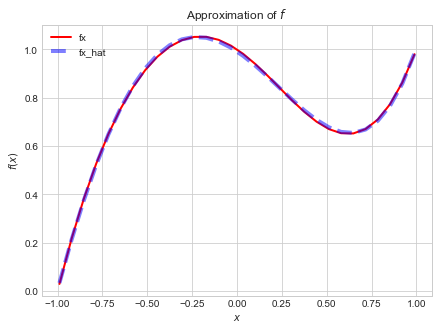

In [195]:
n = 30
xs = np.linspace(-0.99,0.99,n)

fx = f(xs)
fx_hat = f_approx(xs,f,N,M)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, fx, label='fx', linewidth=2, color='red')
ax.plot(xs, fx_hat, label='fx_hat', linewidth=4, linestyle='--', color='blue',alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Approximation of $f$')
ax.legend();
